In [202]:
import pandas as pd
import re
import scipy.stats as stats

from ml_lib.feature_store import configure_offline_feature_store
from ml_lib.feature_store.offline.client import FeatureStoreOfflineClient

configure_offline_feature_store(
    workgroup="primary"
)

In [203]:
data = FeatureStoreOfflineClient.run_athena_query_pandas("""
WITH skad    AS (
    SELECT adgroup
         , campaign
         , first_campaign_id_network
         , first_os_name                       os_name
         , partner
         , first_day                           install_date
         , sum_skad_installs
         , sum_skad_reinstalls
         , sum_conversion_value_total          sum_skad_conversion_value_total
         , sum_conversion_value_7 * 0.75 + sum_conversion_value_8 * 1.25 + sum_conversion_value_9 * 1.75 +
           sum_conversion_value_10 * 2.25 +
           sum_conversion_value_11 * 2.75 + sum_conversion_value_12 * 3.25 + sum_conversion_value_13 * 3.75 +
           sum_conversion_value_14 * 4.25 + sum_conversion_value_15 * 4.75 +
           sum_conversion_value_16 * 5.25 + sum_conversion_value_17 * 5.75 + sum_conversion_value_18 * 6.25 +
           sum_conversion_value_19 * 6.75 + sum_conversion_value_20 * 7.25 +
           sum_conversion_value_21 * 7.75 + sum_conversion_value_22 * 8.25 + sum_conversion_value_23 * 8.75 +
           sum_conversion_value_24 * 9.25 + sum_conversion_value_25 * 9.75 +
           sum_conversion_value_26 * 10.50 + sum_conversion_value_27 * 11.50 + sum_conversion_value_28 * 12.50 +
           sum_conversion_value_29 * 13.50 + sum_conversion_value_30 * 14.50 +
           sum_conversion_value_31 * 15.50 + sum_conversion_value_32 * 16.50 + sum_conversion_value_33 * 17.50 +
           sum_conversion_value_34 * 18.50 + sum_conversion_value_35 * 19.50 +
           sum_conversion_value_36 * 21.00 + sum_conversion_value_37 * 23.00 + sum_conversion_value_38 * 25.00 +
           sum_conversion_value_39 * 27.00 + sum_conversion_value_40 * 29.00 +
           sum_conversion_value_41 * 31.00 + sum_conversion_value_42 * 33.00 + sum_conversion_value_43 * 35.00 +
           sum_conversion_value_44 * 37.00 + sum_conversion_value_45 * 39.00 +
           sum_conversion_value_46 * 41.00 + sum_conversion_value_47 * 43.00 + sum_conversion_value_48 * 45.00 +
           sum_conversion_value_49 * 47.00 + sum_conversion_value_50 * 49.00 +
           sum_conversion_value_51 * 52.50 + sum_conversion_value_52 * 57.50 + sum_conversion_value_53 * 62.50 +
           sum_conversion_value_54 * 67.50 + sum_conversion_value_55 * 72.50 +
           sum_conversion_value_56 * 77.50 + sum_conversion_value_57 * 82.50 + sum_conversion_value_58 * 87.50 +
           sum_conversion_value_59 * 92.50 + sum_conversion_value_60 * 97.50 +
           sum_conversion_value_61 * 112.50 + sum_conversion_value_62 * 137.50 +
           sum_conversion_value_63 * 175.00 AS sum_avg_revenue
         , meta_date
         , 1                                   skad
    FROM etl__tamatem_2cn8s__vip_baloot_mlgax.skad
    )

   , no_skad AS (
    SELECT adgroup
         , campaign
         , first_campaign_id_network
         , os_name
         , partner
         , first_day               install_date
         , SUM(sum_installs)       sum_noskad_installs
         , SUM(sum_reinstalls)     sum_noskad_reinstalls
         , SUM(sum_reattributions) sum_noskad_reattributions
         , SUM(sum_revenue)        sum_noskad_revenue
         , 0                       skad
    FROM etl__tamatem_2cn8s__vip_baloot_mlgax.without_skad
    WHERE os_name = 'ios'
    GROUP BY adgroup
           , campaign
           , first_campaign_id_network
           , os_name
           , partner
           , first_day
    )

   , t_out   AS (
    SELECT adgroup
         , campaign
         , first_campaign_id_network
         , partner
         , install_date
         , skad.sum_skad_installs
         , skad.sum_skad_reinstalls
         , skad.sum_skad_conversion_value_total
         , skad.sum_avg_revenue                                                             skad_revenue
         , skad.sum_avg_revenue * 1.0 / (skad.sum_skad_installs + skad.sum_skad_reinstalls) skad_arpu
         , no_skad.sum_noskad_installs
         , no_skad.sum_noskad_reinstalls
         , no_skad.sum_noskad_revenue                                                       no_skad_revenue
         , no_skad.sum_noskad_revenue * 1.0 /
           (no_skad.sum_noskad_installs + no_skad.sum_noskad_reinstalls +
            no_skad.sum_noskad_reattributions)                                              no_skad_arpu
         , skad.skad                                                                        skad_id
         , no_skad.skad                                                                     no_skad_id
         , CASE
               WHEN skad.skad = 1 AND no_skad.skad = 0 THEN 2
               WHEN skad.skad = 1 THEN 1
               WHEN no_skad.skad = 0 THEN 0
               ELSE 3 END                                                                   has_skad
    FROM skad
         FULL JOIN no_skad
                   USING (adgroup, campaign, first_campaign_id_network, partner, install_date)
    )
SELECT *
FROM t_out;
""")
data = data.replace([np.inf, -np.inf], np.nan)
data.head()

DummyStatsClient._send unknown.athena_query_runs_total:1|c
DummyStatsClient._send unknown.athena_query_queue_ms:159.000000|ms
DummyStatsClient._send unknown.athena_query_execution_ms:5718.000000|ms
DummyStatsClient._send unknown.athena_query_scanned_bytes:8817788|c


,adgroup,campaign,first_campaign_id_network,partner,install_date,sum_skad_installs,sum_skad_reinstalls,sum_skad_conversion_value_total,skad_revenue,skad_arpu,sum_noskad_installs,sum_noskad_reinstalls,no_skad_revenue,no_skad_arpu,skad_id,no_skad_id,has_skad
0,21-99_MAI_M_SA-KW (4d8baf88-cfad-4771-a17e-a7f...,BAL_SC_UA_I_SKAD_SA-KW_MAI (1ecb9265-7bb8-4f39...,1ecb9265-7bb8-4f39-902c-44cc17bffe61,snapchat,2022-09-12,21,0,16,0.0,0.0,3,0,0.0,0.0,1,0,2
1,13-99_MAI_Both_AdsClick_SA-KW (1729076323756081),BAL_TT_UA_I_SKAD_SA-KW_AdEngagers (17290761920...,1729076192068641,tiktok,2022-08-16,8,9,9,0.0,0.0,5,0,0.0,0.0,1,0,2
2,1899_MAI_M_BROAD_SA-KW (1729998279267377),BAL_TT_UA_I_SKAD_SA-KW_MAI (1729998279267345),1729998279267345,tiktok,2022-07-30,1,2,0,0.0,0.0,0,0,0.0,NaN,1,0,2
3,unknown,BAL_Unity_I_SA-KW_MAI_Compatitors1 (62d4186f8f...,62d4186f8f6f7a5eb56c5d5e,unity_ads,2022-07-30,7,1,4,0.0,0.0,<NA>,<NA>,NaN,NaN,1,<NA>,1
4,unknown,BAL_Unity_UA_I_SKAD_SA_MAI (6257e2e8326d45b443...,6257e2e8326d45b443dca065,unity_ads,2022-06-10,1,0,0,0.0,0.0,<NA>,<NA>,NaN,NaN,1,<NA>,1


In [204]:
for i in data.columns:
    temp_counts = data[[i]].value_counts()
    if len(temp_counts) >= 20 or len(temp_counts) == 1:
        print(i)
        print("# of uniques:", len(temp_counts))
    else:
        display(temp_counts)
    print()

adgroup
# of uniques: 12357

campaign
# of uniques: 152

first_campaign_id_network
# of uniques: 151



partner    
unity_ads      314634
apple           11556
tiktok           3417
adwords          2381
snapchat         2348
unknown          2265
app_samurai      1354
twitter           267
facebook          204
Organic           199
speakol           179
mintegral          64
dtype: int64


install_date
# of uniques: 211

sum_skad_installs
# of uniques: 87

sum_skad_reinstalls
# of uniques: 47

sum_skad_conversion_value_total
# of uniques: 86



skad_revenue
0.00            1422
1.25               6
0.75               3
8.25               3
7.75               3
4.75               2
5.25               2
3.25               2
5.75               1
7.25               1
2.25               1
9.00               1
18.50              1
27.00              1
31.00              1
32.25              1
33.00              1
52.50              1
112.50             1
dtype: int64


skad_arpu
# of uniques: 33

sum_noskad_installs
# of uniques: 306

sum_noskad_reinstalls
# of uniques: 1

no_skad_revenue
# of uniques: 3344

no_skad_arpu
# of uniques: 1369

skad_id
# of uniques: 1

no_skad_id
# of uniques: 1



has_skad
0           337414
2              881
1              573
dtype: int64

## Distribution Tests:

### Revenue:

<AxesSubplot:title={'center':'Hist.: Distribution of revenue in SKAD table'}, ylabel='Frequency'>

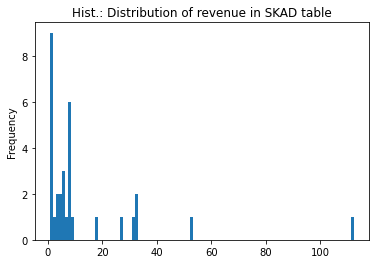

In [205]:
data.skad_revenue[data.skad_revenue > 0][data.skad_id == 1].plot(
    kind = "hist", bins = 100, title = "Hist.: Distribution of revenue in SKAD table"
)

<AxesSubplot:title={'center':'Hist.: Distribution of spends in without_SKAD table'}, ylabel='Frequency'>

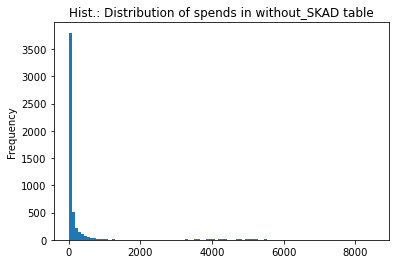

In [206]:
data.no_skad_revenue[data.no_skad_revenue > 0][data.no_skad_id == 0].plot(
    kind = "hist", bins = 100, title = "Hist.: Distribution of spends in without_SKAD table"
)

In [207]:
stats.kstest(data.skad_revenue[data.skad_revenue > 0], data.no_skad_revenue[data.no_skad_revenue > 0])

KstestResult(statistic=0.45511732938252725, pvalue=1.5423316832574585e-06)

In [208]:
stats.kstest(data.skad_revenue[data.skad_id == 1], data.no_skad_revenue[data.no_skad_id == 0])

KstestResult(statistic=0.006512901404817639, pvalue=0.999999963486704)

### ARPU:

<AxesSubplot:title={'center':'Hist.: Distribution of ARPU in SKAD table'}, ylabel='Frequency'>

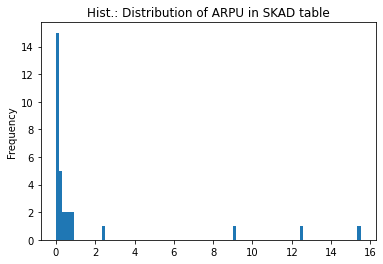

In [209]:
data.skad_arpu[data.skad_arpu > 0][data.skad_id == 1].plot(
    kind = "hist", bins = 100, title = "Hist.: Distribution of ARPU in SKAD table"
)

<AxesSubplot:title={'center':'Hist.: Distribution of ARPU in without_SKAD table'}, ylabel='Frequency'>

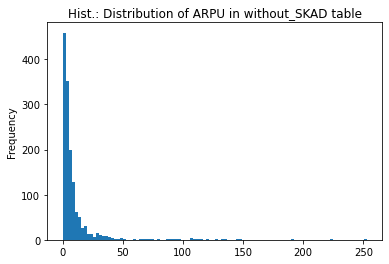

In [210]:
data.no_skad_arpu[data.no_skad_arpu > 0][data.no_skad_id == 0].plot(
    kind = "hist", bins = 100, title = "Hist.: Distribution of ARPU in without_SKAD table"
)

In [211]:
stats.kstest(data.skad_arpu[data.skad_arpu > 0], data.no_skad_arpu[data.no_skad_arpu > 0])

KstestResult(statistic=0.7349439775910365, pvalue=1.1102230246251565e-16)

In [212]:
stats.kstest(data.skad_arpu[data.skad_id == 1], data.no_skad_arpu[data.no_skad_id == 0])

KstestResult(statistic=0.9748355867343749, pvalue=0.0)

## Mean of all tests:

In [213]:
data2 = data[data.has_skad == 2]
data2.head()

,adgroup,campaign,first_campaign_id_network,partner,install_date,sum_skad_installs,sum_skad_reinstalls,sum_skad_conversion_value_total,skad_revenue,skad_arpu,sum_noskad_installs,sum_noskad_reinstalls,no_skad_revenue,no_skad_arpu,skad_id,no_skad_id,has_skad
0,21-99_MAI_M_SA-KW (4d8baf88-cfad-4771-a17e-a7f...,BAL_SC_UA_I_SKAD_SA-KW_MAI (1ecb9265-7bb8-4f39...,1ecb9265-7bb8-4f39-902c-44cc17bffe61,snapchat,2022-09-12,21,0,16,0.0,0.0,3,0,0.0,0.0,1,0,2
1,13-99_MAI_Both_AdsClick_SA-KW (1729076323756081),BAL_TT_UA_I_SKAD_SA-KW_AdEngagers (17290761920...,1729076192068641,tiktok,2022-08-16,8,9,9,0.0,0.0,5,0,0.0,0.0,1,0,2
2,1899_MAI_M_BROAD_SA-KW (1729998279267377),BAL_TT_UA_I_SKAD_SA-KW_MAI (1729998279267345),1729998279267345,tiktok,2022-07-30,1,2,0,0.0,0.0,0,0,0.0,NaN,1,0,2
5,2599_AEO_M_BROAD_SA_LVL4 (1750100159825937),BAL_TT_UA_I_SA_AEO (1750100159430705),1750100159430705,tiktok,2022-12-27,1,1,0,0.0,0.0,<NA>,<NA>,NaN,NaN,1,0,2
6,21-99_MAI_M_SA-KW (4d8baf88-cfad-4771-a17e-a7f...,BAL_SC_UA_I_SKAD_SA-KW_MAI (1ecb9265-7bb8-4f39...,1ecb9265-7bb8-4f39-902c-44cc17bffe61,snapchat,2022-08-11,29,0,24,0.0,0.0,1,0,0.0,0.0,1,0,2


### Revenue:

<AxesSubplot:ylabel='Frequency'>

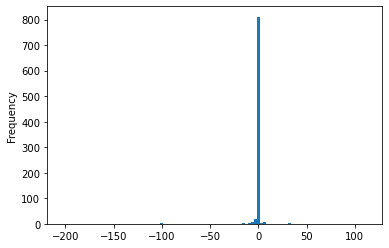

In [214]:
temp_data = data2.skad_revenue - data2.no_skad_revenue
temp_data.plot(kind = "hist", bins = 100)

In [215]:
stats.ttest_1samp(temp_data.dropna().to_numpy(), popmean = 0)

Ttest_1sampResult(statistic=-1.4321308159443455, pvalue=0.15246597164761017)

### ARPU:

<AxesSubplot:ylabel='Frequency'>

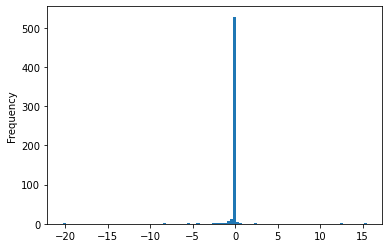

In [216]:
temp_data = data2.skad_arpu - data2.no_skad_arpu
temp_data.plot(kind = "hist", bins = 100)

In [217]:
stats.ttest_1samp(temp_data.dropna().to_numpy(), popmean = 0)

Ttest_1sampResult(statistic=-1.2680088750731284, pvalue=0.20531612486067308)

## Mean of non-zero tests:

In [218]:
data3 = data2[(data2.skad_revenue > 0) | (data2.no_skad_revenue > 0)]
data3.head()

,adgroup,campaign,first_campaign_id_network,partner,install_date,sum_skad_installs,sum_skad_reinstalls,sum_skad_conversion_value_total,skad_revenue,skad_arpu,sum_noskad_installs,sum_noskad_reinstalls,no_skad_revenue,no_skad_arpu,skad_id,no_skad_id,has_skad
30,2599_AEO_M_BROAD_SA-KW_ACO (1743759441536033),BAL_TT_UA_I_SA-KW_AEO_new (1743759431029809),1743759431029809,tiktok,2022-10-09,19,18,36,0.00,0.000000,10,0,2.990,0.299000,1,0,2
47,21-99_MAI_M_SA-KW (4d8baf88-cfad-4771-a17e-a7f...,BAL_SC_UA_I_SKAD_SA-KW_MAI (1ecb9265-7bb8-4f39...,1ecb9265-7bb8-4f39-902c-44cc17bffe61,snapchat,2022-07-07,49,0,38,5.25,0.107143,9,0,0.000,0.000000,1,0,2
56,2599_AEO_M_BROAD_SA_LVL4 (1750100159825937),BAL_TT_UA_I_SA_AEO (1750100159430705),1750100159430705,tiktok,2022-12-04,47,23,67,0.00,0.000000,16,0,1.061,0.044208,1,0,2
15716,1899_AEO_M_BROAD_KW_ACO (1738681892470834),BAL_TT_UA_I_SA-KW_AEO (1738681647508514),1738681647508514,tiktok,2022-07-30,9,3,11,0.00,0.000000,13,0,3.990,0.266000,1,0,2
15721,1899_AEO_M_BROAD_KW_ACO (1738681892470834),BAL_TT_UA_I_SA-KW_AEO (1738681647508514),1738681647508514,tiktok,2022-09-17,1,0,1,0.00,0.000000,0,0,1.990,NaN,1,0,2


### Revenue:

<AxesSubplot:ylabel='Frequency'>

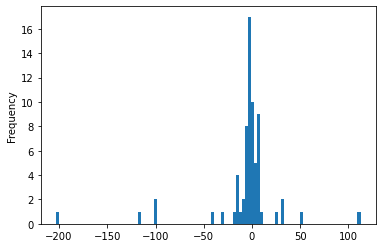

In [219]:
temp_data = data3.skad_revenue - data3.no_skad_revenue
temp_data.plot(kind = "hist", bins = 100)

In [220]:
stats.ttest_1samp(temp_data.dropna().to_numpy(), popmean = 0)

Ttest_1sampResult(statistic=-1.442430519968758, pvalue=0.15377134650830154)

### ARPU:

<AxesSubplot:ylabel='Frequency'>

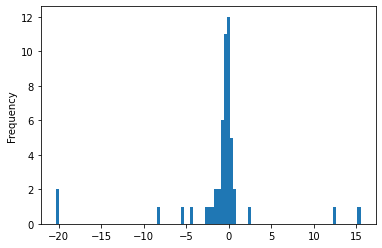

In [221]:
temp_data = data3.skad_arpu - data3.no_skad_arpu
temp_data.plot(kind = "hist", bins = 100)

In [222]:
stats.ttest_1samp(temp_data.dropna().to_numpy(), popmean = 0)

Ttest_1sampResult(statistic=-1.2750818946565325, pvalue=0.20817344569381446)